<h1>Efficient Python Scripts Tutorial: Guided Solution</h1>

<h2>Introduction</h2>

This tutorial, developed as part of the <a href="http://www.cse.chalmers.se/edu/year/2017/course/DAT300/">DAT300 / DIT615 Data-driven support for cyber-physical systems</a>, aims to give some simple and useful tips on how to improve the performance of your Python scripts. Python is now ubiquitous in many domains such as machine learning, embedded devices, scientific computing and networking. To follow the tutorial, you are expected to be at least "conversational" in Python that is to understand its syntax and having already programmed at least once in it. Let's note that the tutorial focuses on Python but many of the below tips are regardless applicable to other scripting languages.

**NB**: *This solution saves the fake databases and any generated files in a "data" subfolder. If you want to use the same folder as the notebook itself, simply set `DATA_FOLDER` to "" in the first coding cell below.*


In [58]:
DATA_FOLDER = "data"

# Part 0 -- Preliminaries

Execute the following cell to initialize the needed utils.

In [47]:
from random import random, getrandbits
from timeit import timeit
from matplotlib import pyplot as plt

# Remember to use os.path.join to be OS-agnostic in the filepaths

from os.path import join, exists
from os import mkdir

DATA_FOLDER = "data"

"""
    Here are some utils that we will use in this tutorials
"""

# This generates a fake database with n rows
def generate_database(n):
    for _ in range(n):
        yield hex(getrandbits(60*4))[2:].zfill(60), random(), random(), random()

# This saves the database to a file without having had the object fully generated in memory
def stream2file(data, filename):
    with open(filename, "w") as outputfile:
        for record in data:
            print(record[0], *['{0:.10f}'.format(r) for r in record[1:]], sep=',', file=outputfile)

# This does the opposite, ie this is a generator for a saved database
def file2stream(filename, folder=DATA_FOLDER):
    with open(join(folder,filename), "r") as inputfile:
        for line in inputfile.readlines():
            record = line.split(',')
            yield record[0], *[float(x) for x in record[1:]]

# Macro to generate a set of database of different sizes
def generate_all_databases(max_size_in_bytes=100_000_000, nb_files=10, data_directory=DATA_FOLDER):
    if not exists(data_directory):
        mkdir(data_directory)
    for i in range(1,nb_files+1):
        n = i*max_size_in_bytes//(100*nb_files)
        stream2file(generate_database(n), join(data_directory,f"data{n}.csv"))

# Macro to plot several lines sharing the same X axis
def plotNlines(X, lines):
    for name, points in lines:
        plt.plot(X, points, marker='o', label=name)
    plt.legend()
    plt.show()
    
# Default parameters for the experiments
M, N = 100_000_000, 10
M1 = M//(100*N)
sizes = [M1*(i+1) for i in range(2*N)]

# Generates a sequence of 'iterations' sizes from 'minsize' up to 'iterations*minsize'
def test_sizes(minsize=M1, iterations=N):
    for x in range(iterations):
        yield minsize*(x+1)

"""
    Here is a simple compare function that compare several implementation 
    by measuring the execution time for different size of input
"""
    
def compare(*args, iterations=N, minsize=M1, repetition=1):
    X = []
    Y = [(args[i][0],[]) for i in range(len(args))]    
    for n in test_sizes(minsize, iterations):
        X.append(n)
        for i in range(len(args)):
            Y[i][1].append(timeit(args[i][1](n), number=repetition))
    plotNlines(X, Y)
    
"""
    This is a shortcut to generate a sequence of random numbers of size n
"""
generator = lambda n : (random() for _ in range(n))

"""
    This is a shortcut to create 20 lists of increasing size (from 100000 elements to 2000000)
    And stores the lists in a dicttionary so that lists[n] is a list of size n
"""
lists = dict(zip( (n for n in sizes), (list(generator(n)) for n in sizes) ))

If not done yet, generate the example database (here about 500MB of data is generated in the "data" subfolder).

In [42]:
generate_all_databases(M, N, data_directory="data")

# Part 1 -- Remember your DATA structures' complexities


## Example (A): Popping an element from a list


In [3]:
from collections import deque

def pop_one_quarter_list(L):
    for _ in range(len(L)//4):
        L.pop(0)

def pop_one_quarter_queue(L):
    for _ in range(len(L)//4):
        L.popleft()

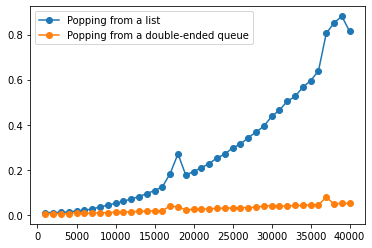

In [5]:
# Initialization time is also included

compare(("Popping from a list", lambda n: lambda: pop_one_quarter_list(list(generator(n)))),
         ("Popping from a double-ended queue", lambda n: lambda: pop_one_quarter_queue(deque(generator(n)))),
        minsize=1000, iterations=40, repetition=10)

### Explanations

Always keep in mind that Python lists are what we call in algorithmic terms "dynamic arrays". They rely on fixed arrays (assuming default Python implementation) and when more space is required, the allocated space doubles; this gives an amortized $O(1)$ cost per append operation (between $n$ and $2n$, only 1 operation has linear cost, the memory re-allocation, the rest having constant cost). Similarly, the same holds for popping from the end of the list.

However, when deleting an element or popping from the left of a list, the trick of doubling does not work any longer and the usual implementation requires to reallocate the list. That means if you pop or delete  $O(n)$ of your list, the cost will be $O(n^2)$ instead of the linear cost obtained using a double-chained list.

Hence keep deleting elements from lists for convenience only when manipulating short lists!

**Very important page to always have in your bookmarks**: https://wiki.python.org/moin/TimeComplexity

#### Work-around

As explained above, if you only need to pop / delete elements from the beginning or the end of the list / queue, then deque is the best data structure for your need. Though deleting elements somewhere in the middle would not be efficient then. In that case, you should consider if using a `set()` is more appropriate or have a look into the sorted structures (binary trees, etc).

## Example (b): Using a list or a dictionary?


In [6]:
from math import sqrt

def using_dict(n,i):
    n, i = int(sqrt(n)), int(sqrt(i))
    d = {}
    for a in range(i):
        for b in range(i):
            d[(a,b)] = random()    
    sum(d.values())
    
def using_lists(n,i):
    n, i = int(sqrt(n)), int(sqrt(i))
    L = [[0]*n for _ in range(n)]
    for a in range(i):
        for b in range(i):
            L[a][b] = random()    
    sum(x for row in L for x in row)

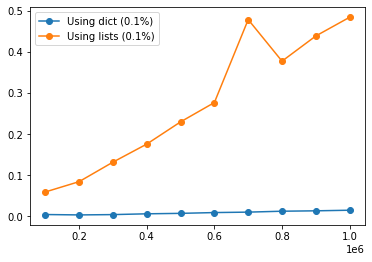

In [7]:
# Includes also initialization time
    
compare(("Using dict (0.1%)", lambda n: lambda: using_dict(n,n*0.01)),
         ("Using lists (0.1%)", lambda n: lambda: using_lists(n,n*0.01)),
        iterations=10, repetition=10)

OK a hash-map is a clear winner for an almost empty data-structure, but actually this holds till at least 25-33% of the hash-map is full.

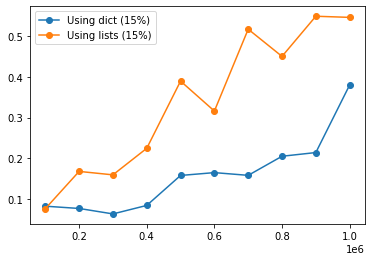

In [8]:
compare(("Using dict (15%)", lambda n: lambda: using_dict(n,n*0.1)),
         ("Using lists (15%)", lambda n: lambda: using_lists(n,n*0.1)),
        iterations=10, repetition=10)

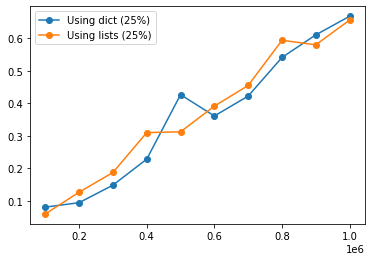

In [9]:
compare(("Using dict (25%)", lambda n: lambda: using_dict(n,n*0.25)),
         ("Using lists (25%)", lambda n: lambda: using_lists(n,n*0.25)),
        iterations=10, repetition=10)

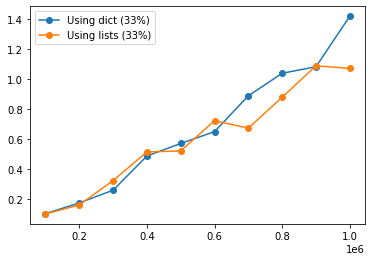

In [22]:
compare(("Using dict (33%)", lambda n: lambda: using_dict(n,n*0.33)),
         ("Using lists (33%)", lambda n: lambda: using_lists(n,n*0.33)),
       iterations=10, repetition=10)

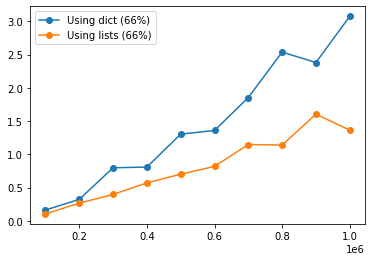

In [23]:
compare(("Using dict (66%)", lambda n: lambda: using_dict(n,n*0.66)),
         ("Using lists (66%)", lambda n: lambda: using_lists(n,n*0.66)),
        iterations=10, repetition=10)

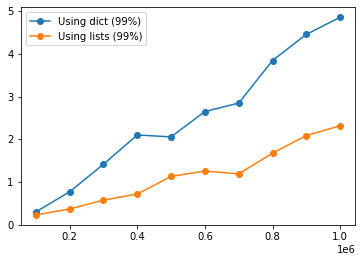

In [24]:
compare(("Using dict (99%)", lambda n: lambda: using_dict(n,n*0.99)),
         ("Using lists (99%)", lambda n: lambda: using_lists(n,n*0.99)),
        iterations=10, repetition=10)

Hence we can get up to 4-5 times slower execution time when using a full hash-map instead of a linear data structure in this example.

### Explanations

Python dictionaries are nothing else what we usually call a hash table in algorithmic terms. As you know, hash table have constant time access assuming load factor stays under some threshold. Python's dictionaries for example resizes when roughly 2/3 of the table is full, and results in a costly operation but that can be amortized through time. Access to each element is $O(1)$ on average (assuming a good hash function is used and keys are drawn uniformly at random) and iteration is $O(k)$ if k keys are stored.

The advantage of using a pre-allocated table, using $O(n^2)$ space, resides in avoiding to waste space when the table is expected to be close to full. Access to any key is always $O(1)$ without further assumption.

Taking this into account, a good rule of thumb is to favor storage in a dictionary if it cannot be replaced by a direct-access structure (like a matrix) where at least 25-33% of the cells would be used in expectation.

# Part 2 -- Remember to stream your DATA


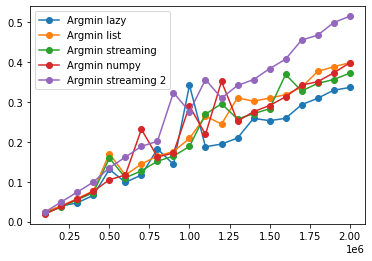

In [39]:
from math import sin, cos
import numpy as np

def argmin_lazy(L):
    return L.index(min(L))

def argmin(L):
    argminL, minL = 0, L[0]
    for i in range(1, len(L)):
        if L[i] < minL:
            argminL, minL = i, L[i]
    return argminL

def argmin_streaming(L):
    argminL, minL = 0, next(L)
    for i, elem in enumerate(L):
        if elem < minL:
            argminL, minL = 1+i, elem
    return argminL

def argmin_streaming2(L):
    return min((elem, i) for i, elem in enumerate(L))[1]

def example_generator(n):
    for x in lists[n]:
        yield sin(x)*cos(x)
        
def example_list(n):
    return list(example_generator(n))

compare(("Argmin lazy", lambda n: lambda: argmin_lazy(example_list(n))),
         ("Argmin list", lambda n: lambda: argmin(example_list(n))),
        ("Argmin streaming", lambda n: lambda: argmin_streaming(example_generator(n))),
        ("Argmin numpy", lambda n: lambda: np.argmin(example_list(n))),
        ("Argmin streaming 2", lambda n: lambda: argmin_streaming2(example_generator(n))),
        iterations=20, repetition=1)


### Explanations

Interesting enough, the lazy one liner is the best in this example. We note that trying to abuse of streaming in order to write one-liners is not a great idea here. We are entering the world of optimization going that line further, so let's stick to efficiency here!

#  Part 3 -- Remember to use multiprocessing for repetitive tasks

Let's compare a sequential implementation to a parallel one.

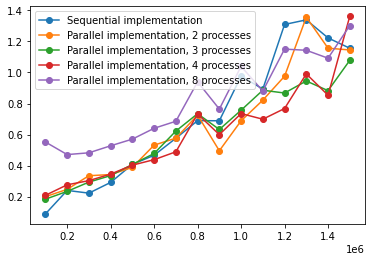

In [11]:
from math import sin, cos, sqrt
import multiprocessing as mp

def complicated_simulation(n):
    return sqrt(n)*random()/(cos(random())*sin(random()))

def avg_simulations(nb_runs):
    return sum(complicated_simulation(nb_runs) for _ in range(nb_runs))/nb_runs

def avg_sim_parallel(nb_runs, nb_processes):
    with mp.Pool(processes=nb_processes) as pool:
        return sum(pool.map(avg_simulations, [nb_runs//nb_processes]*nb_processes, 1))/nb_processes
        
compare(("Sequential implementation", lambda n: lambda: avg_simulations(n)),
        ("Parallel implementation, 2 processes", lambda n: lambda: avg_sim_parallel(n, 2)),
        ("Parallel implementation, 3 processes", lambda n: lambda: avg_sim_parallel(n, 3)),
        ("Parallel implementation, 4 processes", lambda n: lambda: avg_sim_parallel(n, 4)),
        ("Parallel implementation, 8 processes", lambda n: lambda: avg_sim_parallel(n, 8)),
        iterations=15, repetition=2)

### Explanations

In the example above, the best results are most often obtained when using only 2 parallel processes. This is because my own machine has only 2 physical cores and 2 threads can be run on each core (hyperthreading). 

Depending on your system's configuration, you might experience different results.

# Part 4 -- Remember the different types of memory



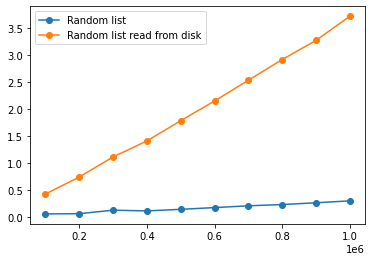

In [27]:
from math import sqrt
compare(("Random list", lambda n: lambda: [sqrt(random()) for _ in range(n)]),
        ("Random list read from disk", lambda n: lambda: 
             [r[1] for r in file2stream(join(DATA_FOLDER,f"data{n}.csv"))]),
        iterations=10, repetition=3)

### Explanations

And remember to stream your database if it doesn't fit in main memory!

An alternative to reading the language agnostic file from disk (such as a csv file), one can also serialize the data which will be faster than parsing the file (see next section).

# Part 5 -- Remember to load efficiently your DATA in memory


In [50]:
import pickle

import numpy as np

def savedump(myobj, filename, folder=DATA_FOLDER):
    with open(join(folder,filename),'wb') as f:
        pickle.dump(myobj, f)

def loaddump(filename, folder=DATA_FOLDER):
    with open(join(folder,filename),'rb') as f:
        return pickle.load(f)

my_db = {}

def load_database(n):
    my_db[n] = list(file2stream(f"data{n}.csv"))
    
def load_database_numpy_v1(n):
    my_db[n] =  np.array(list(file2stream(f"data{n}.csv")))
    
def load_database_numpy_v2(n):
    data = list(zip(*[line for line in file2stream(f"data{n}.csv")]))
    my_db[n] =  {}
    my_db[n]["ID"] = data[0]
    my_db[n]["floats"] = np.array(data[1:], dtype=float)

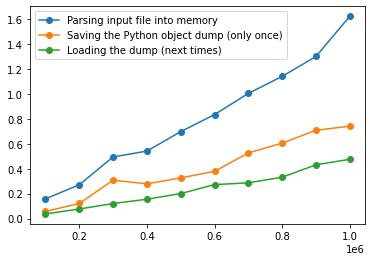

In [51]:
compare(("Parsing input file into memory", lambda n: lambda: load_database(n)),
        ("Saving the Python object dump (only once)", lambda n: lambda: savedump(my_db[n], f"data{n}.dump")),
        ("Loading the dump (next times)", lambda n: lambda: loaddump(f"data{n}.dump")),
        iterations=10)

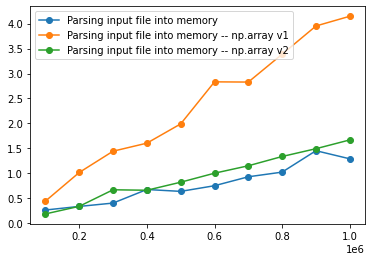

In [11]:
compare(("Parsing input file into memory", lambda n: lambda: load_database(n)),
        ("Parsing input file into memory -- np.array v1", lambda n: lambda: load_database_numpy_v1(n)),
        ("Parsing input file into memory -- np.array v2", lambda n: lambda: load_database_numpy_v2(n)),
        
        iterations=10)

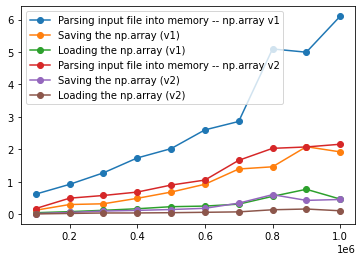

In [12]:
compare(("Parsing input file into memory -- np.array v1", lambda n: lambda: load_database_numpy_v1(n)),
        ("Saving the np.array (v1)", lambda n: lambda: savedump(my_db[n], f"data{n}-v1.dump")),
        ("Loading the np.array (v1)", lambda n: lambda: loaddump(f"data{n}-v1.dump")),
        
        ("Parsing input file into memory -- np.array v2", lambda n: lambda: load_database_numpy_v2(n)),
        ("Saving the np.array (v2)", lambda n: lambda: savedump(my_db[n], f"data{n}-v2.dump")),
        ("Loading the np.array (v2)", lambda n: lambda: loaddump(f"data{n}-v2.dump")),
        
        iterations=10)

Individual loading times could be checked to realize the improvement with the v2 memory storage comparted with an inefficient parsing (could easily be **50 times faster** as on my machine!).

In [53]:
repeat(lambda: load_database_numpy_v1(1000000), repeat=3, number=1)

[4.637801012999262, 4.9464884490007535, 4.781587424004101]

In [57]:
load_database_numpy_v2(1000000)
savedump(my_db[1000000], f"data1000000-v2.dump")
repeat(lambda: loaddump(f"data1000000-v2.dump"), repeat=3, number=1)

[0.11697513599938247, 0.10747540100419428, 0.10487028901115991]

### Explanations

The advantage in terms of efficiency is very clear!

## And watch out when using copy and deepcopy of your objects


Let's compare the efficiency of the copy module with a naive ad hoc based copy:

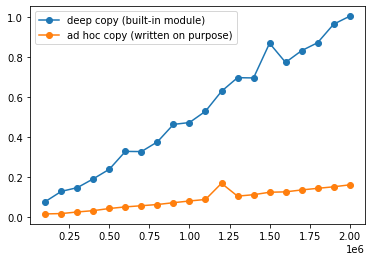

In [5]:
from copy import copy, deepcopy

class MyObject:
    def __init__(self, n):
        self.mylist = [random() for _ in range(n)]

class MyObjectWithCopy(MyObject):
    def copy_my_object(self):
        a = MyObject(0)
        a.mylist = self.mylist[:] 
        return a

compare(("deep copy (built-in module)", lambda n: lambda: deepcopy(MyObjectWithCopy(n))),
        ("ad hoc copy (written on purpose)", lambda n:  lambda: MyObjectWithCopy(n).copy_my_object()),
       iterations=20)

### Explanations

Interesting fact, the deep copy is much slower than the ad hoc copy! Very surprising? At first yes, but you have to consider that Python objects have many hidden fields that will require an inspection upon performing a thorough deep copy of the objects. In this example, the ad hoc copy enjoying the efficiency of the freshly built object resulting from a call to the init function performs better.

# Part 6 -- Remember that DATA representation does always matter


In [6]:
import struct
import numpy as np

def convert_db_record_to_binary_record(record):
    return bytes.fromhex(record[0]), [struct.pack("f", record[1+i]) for i in range(3)]

def convert_db_to_binary(database):
    # try to store the database in a more compact representation
    def bin_record_to_bytes(record):
        id_hex, numbers_float = convert_db_record_to_binary_record(record)
        return [id_hex]+numbers_float
    return [bin_record_to_bytes(record) for record in database]

def stream2binfile(data, filename, folder=DATA_FOLDER):
    with open(join(folder, filename), "wb") as outputfile:
        for record in data:
            id_hex, numbers_float = convert_db_record_to_binary_record(record)
            outputfile.write(id_hex)
            for number in numbers_float:
                outputfile.write(number)
                
def binfile2stream(filename, folder=DATA_FOLDER):
    with open(join(folder, filename), "rb") as file:
        record = file.read(42)
        while record:
            yield record[:30].hex(), *[struct.unpack("f", record[30+i*4:30+(i+1)*4])[0] for i in range(3)]
            record = file.read(42)

def generate_bin_databases(max_size_in_bytes=100_000_000, nb_files=10):
    for i in range(1,nb_files+1):
        n = i*max_size_in_bytes//(100*nb_files)
        stream2binfile(generate_database(n), f"data{n}.bin")
        savedump(convert_db_to_binary(generate_database(n)),f"data-bin{n}.dump")
        
generate_bin_databases() 

Let's then compare the two strategies, first in terms of space: the second one using 42 bytes instead 100 per data point, generates of course a database 42% of the original size. If doubles were used, 54% could be reached instead.
Now let's compare in terms of loading time, will we experience also only 42% loading time?

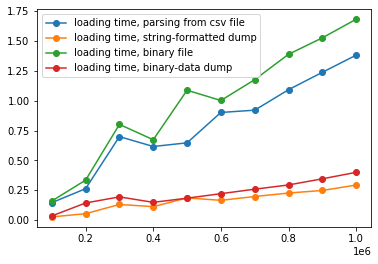

In [9]:
compare(("loading time, parsing from csv file", 
         lambda n: lambda: list(file2stream(f"data{n}.csv"))),
        ("loading time, string-formatted dump", 
         lambda n: lambda: loaddump(f"data{n}.dump")),
        ("loading time, binary file", 
         lambda n: lambda: list(binfile2stream(f"data{n}.bin"))),
        ("loading time, binary-data dump", 
         lambda n: lambda: loaddump(f"data-bin{n}.dump")))

### Explanations

Binary reading is actually slightly worse in this example, the main reason might be that the hex string needs now a conversion whereas it was a simple copy when saving an ascii string in the file. So smaller size does not always mean shorter times, but in many situations being efficient on size also translates on time. A typical example of such a case is when data needs to be transmitted over the network, smaller file sizes can lead to great improvements in this case.